In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML  

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import warnings
# Suppress convergence warnings
warnings.filterwarnings("ignore", category=UserWarning)

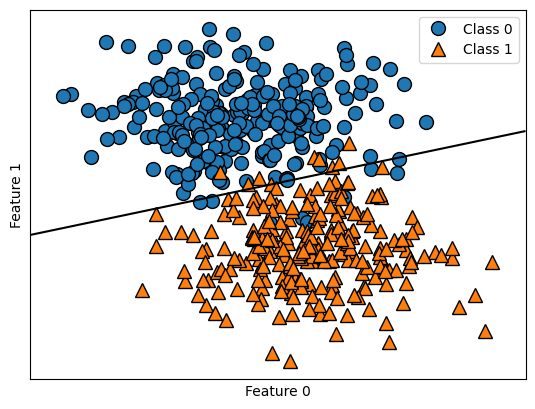

Costs of model          (with internal train iteration): 0.95
Costs of normal model   (with external train iteration): 0.95
Costs of weighted model (with external train iteration): 0.96


In [26]:
import mglearn


# Function to update weights for misclassified samples
def update_weights(model, X, y, weights):
    y_pred = model.predict(X)
    incorrect = (y_pred != y)
    # Increase the weight for misclassified samples
    weights[incorrect] = 2
    dic_weights = {0: 1, 1: weights.mean()}
    return dic_weights

# Generate data
X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=1.0, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models for two scenarios
model_normal = LogisticRegression(solver='saga', max_iter=1, warm_start=True)
model_weighted = LogisticRegression(solver='saga', max_iter=1, warm_start=True, class_weight=None)

# Initial settings
iterations = 200
costs_normal = []
costs_weighted = []
# Initial weights for samples
weights = np.ones_like(y_train, dtype=float)

# Training models
for i in range(iterations):
    # Training normal model
    model_normal.fit(X_train, y_train)
    y_pred_prob_normal = model_normal.predict_proba(X_train)
    cost_normal = log_loss(y_train, y_pred_prob_normal)
    costs_normal.append(cost_normal)

    # Training weighted model
    if i == 0:
        model_weighted.fit(X_train, y_train)
    class_weight = update_weights(model_weighted, X_train, y_train, weights)
    model_weighted.set_params(class_weight=class_weight)
    model_weighted.fit(X_train, y_train)
    y_pred_prob_weighted = model_weighted.predict_proba(X_train)
    cost_weighted = log_loss(y_train, y_pred_prob_weighted)
    costs_weighted.append(cost_weighted)

model_Base = LogisticRegression(solver='saga', max_iter=iterations)
model_Base.fit(X_train, y_train)

mglearn.plots.plot_2d_separator(model_Base, X, fill=False, eps=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1"])
plt.show()

print(f'Costs of model          (with internal train iteration): {model_Base.score(X_test, y_test)}')
print(f'Costs of normal model   (with external train iteration): {model_normal.score(X_test, y_test)}')
print(f'Costs of weighted model (with external train iteration): {model_weighted.score(X_test, y_test)}')


In [5]:
# Setting up animation
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title("Normal Training")
axes[1].set_title("Weighted Training")
lines_normal, = axes[0].plot([], [], label='Cost', color='blue')
lines_weighted, = axes[1].plot([], [], label='Cost', color='orange')

# Initializing plots
ylim = np.max(costs_normal)
ylim = np.max([ylim, np.max(costs_weighted)])
for ax in axes:
    ax.set_xlim(0, iterations)
    ax.set_ylim(0, ylim*2)
    ax.set_xlabel("iterations")
    ax.set_ylabel("Cost")
    ax.grid()
    ax.legend()

iter = 0
cycles = 1
def fun_animation(frame):
    global iter
    iter += 1
    # Exit condition after specified cycles
    if iter >= iterations * cycles:  # Stop after the permitted cycles
        # plt.close(fig)  # Closes the plot window
        return lines_normal, lines_weighted
    # Update the lines with new data
    lines_normal.set_data(range(frame + 1), costs_normal[:frame + 1])
    lines_weighted.set_data(range(frame + 1), costs_weighted[:frame + 1])
    return lines_normal, lines_weighted

# Running animation
ani = FuncAnimation(fig, fun_animation, frames=iterations, interval=20, blit=True)
plt.tight_layout()
display(HTML(ani.to_jshtml()))
plt.close()